In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
# Apply the default theme
sb.set_theme()

In [2]:
import scipy.stats as sts

In [3]:
out_dir = "out_dense"

In [4]:
datasets = ['frogs', 'google_reviews', 'ccrf', 'digits', 'olivetti_faces', 'bcw']
algorithms = ['opf', 'opf_snn']
datasets.sort()

In [5]:
col_name = {"opf": "OPF", "opf_snn": "OPF$_{SNN}$"}

### Plots the relation between # clusters and $k_{max}$

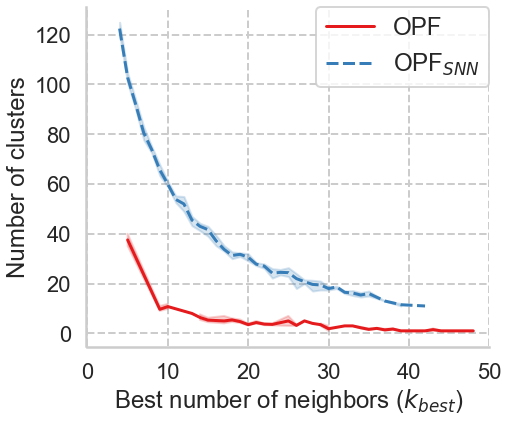

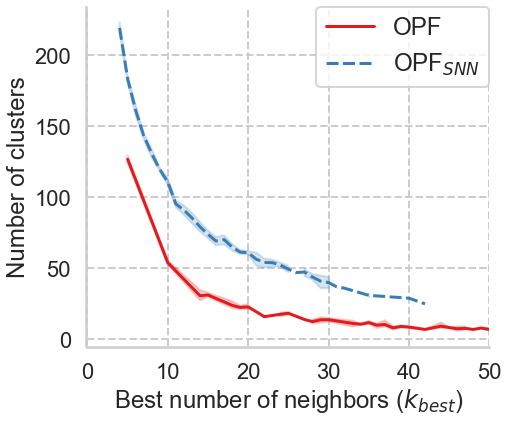

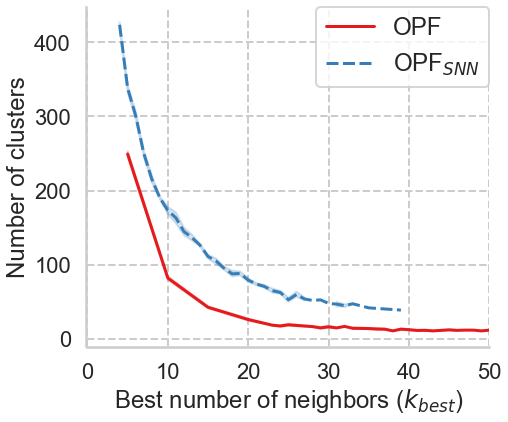

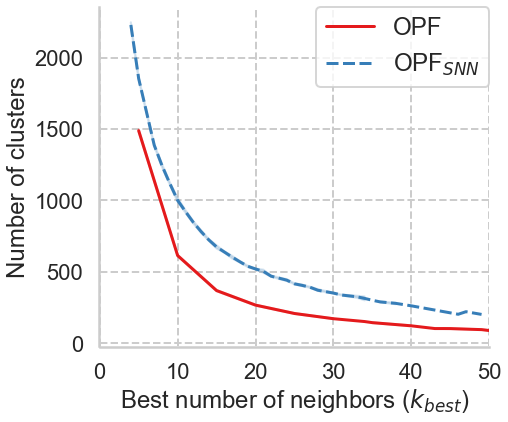

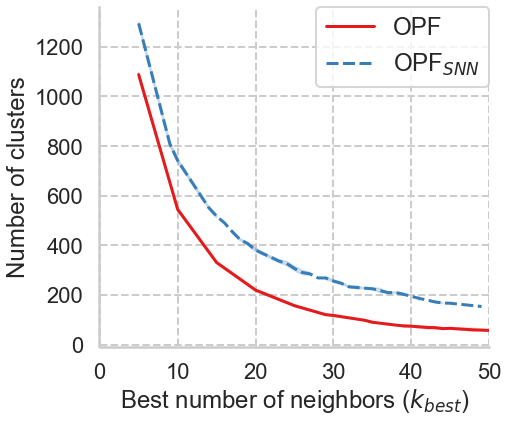

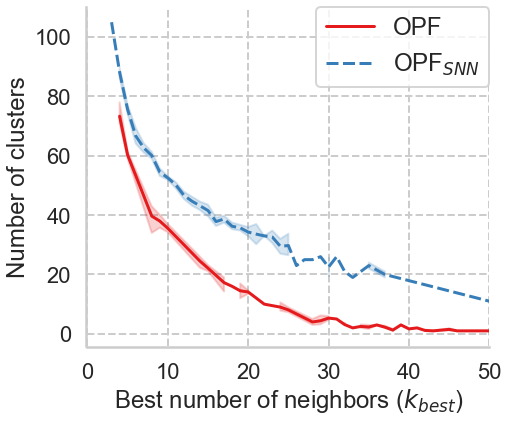

In [23]:
# sb.set_theme(style='whitegrid', font_scale=2.1)
sb.set_context("poster")
sb.set_style('whitegrid', {"context": "poster", 'grid.linestyle': '--', "font_scale": 2.1})
sb.color_palette(palette='Set1', n_colors=2)

plt_fname = "clusters_kbest"
for ds in datasets:
    
    for f in os.scandir('/'.join(['..', out_dir])):

        if ds in f.name:

            df = pd.read_csv(f.path, header=[0])
            df[['algorithm']] = df[['algorithm']].applymap(lambda x: col_name.get(x))
            
            g = sb.relplot(data=df, x="k_best", y="n_clusters", hue="algorithm",
                           style="algorithm", markers=False,
                           kind="line", height=6, aspect=1.2, palette='Set1',
                           legend='brief', facet_kws={'legend_out': False})
            g.set(xlabel="Best number of neighbors ($k_{best}$)", ylabel="Number of clusters")
            # g.set_xticklabels([x for x in range(0, 60, 5)])
            # g.set(title=f"Dataset: {ds.upper()}", xlabel="Best number of neighbors (k$_{best}$)", ylabel="Number of clusters")
            g.set(xlim=(0,50))
            sb.despine(offset=1, trim=False)
            plt.tight_layout(pad=.5)
            plt.legend(fontsize='medium', frameon=True, ncol=1, markerfirst=True, shadow=False, borderaxespad=0)
            plt.savefig(f"./figs/{ds}_{plt_fname}.pdf", format='pdf', bbox_inches='tight')
            plt.show()

### Plots the relation betwenn $k_{max}$ and $k_{best}$

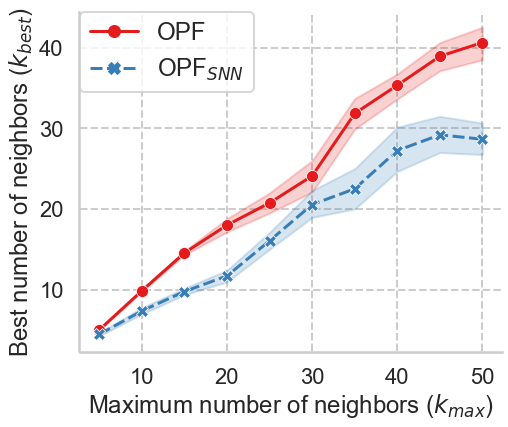

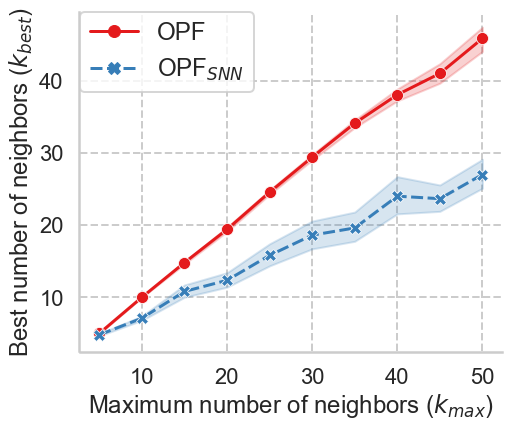

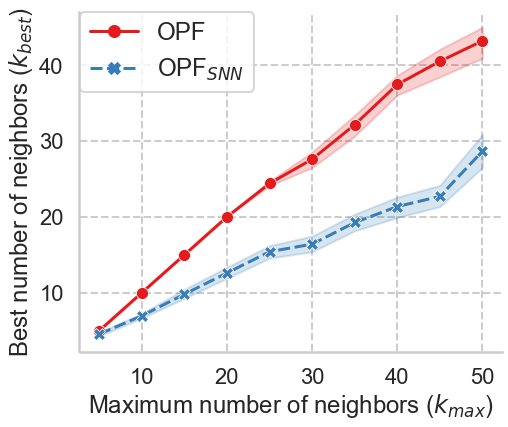

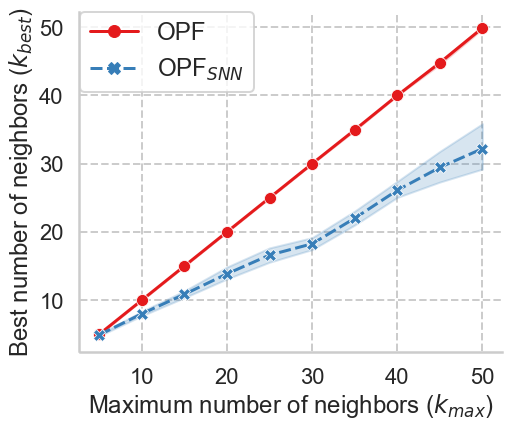

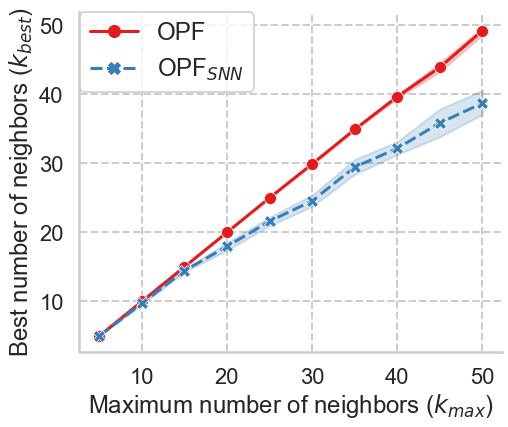

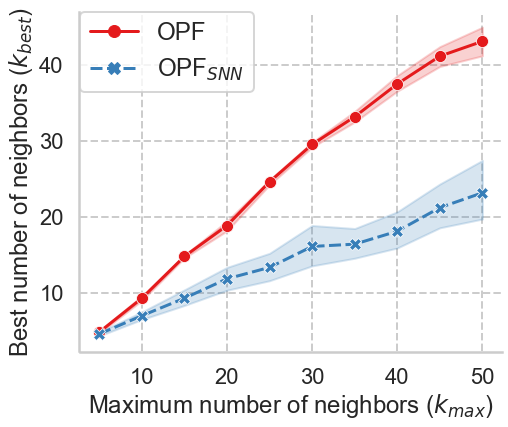

In [25]:
sb.set_context("poster")
sb.set_style('whitegrid', {"context": "poster", 'grid.linestyle': '--', "font_scale": 2.2})

plt_fname = "kmax_kbest"
for ds in datasets:
    
    for f in os.scandir('/'.join(['..', out_dir])):

        if ds in f.name:

            df = pd.read_csv(f.path, header=[0])
            df[['algorithm']] = df[['algorithm']].applymap(lambda x: col_name.get(x))
            
            g = sb.relplot(data=df, x="k_max", y="k_best", hue="algorithm", 
                           kind="line", height=6, aspect=1.2, palette="Set1",
                           style="algorithm", markers=True,
                           legend='brief', facet_kws={'legend_out': False})
            g.set(xlabel="Maximum number of neighbors ($k_{max}$)", ylabel="Best number of neighbors ($k_{best}$)")
            # g.set(title=f"Dataset: {ds.upper()}", xlabel="Maximum number of neighbors (k$_{max}$)", ylabel="Best number of neighbors (k$_{best}$)")
            sb.despine(offset=1, trim=False)
            plt.tight_layout(pad=.5)
            plt.legend(fontsize='medium', frameon=True, ncol=1, markerfirst=True, shadow=False, borderaxespad=0)
            plt.savefig(f"./figs/{ds}_{plt_fname}.pdf", format='pdf', bbox_inches='tight')
            plt.show()

In [25]:
def read_df_from_csv(ds_name: str):
    
    col_name = {"opf": "OPF", "opf_snn": "OPF$_{SNN}$"}
    
    for f in os.scandir('/'.join(['..', out_dir])):

        if ds_name in f.name:

            # print("Reading '", ds_name, "' dataset...")
            _df = pd.read_csv(f.path, header=[0])
            _df[['algorithm']] = _df[['algorithm']].applymap(lambda x: col_name.get(x))
    
    return _df

### Generaring statistics for labeled data results

In [39]:
algo_map = {"opf": "OPF", "opf_snn": "OPF$_{SNN}$"}
metric_map = {"completeness": "C", "homogeneity": "H", "v_measure": "V", "adjusted_rand_index": "ARI", "adjusted_mutual_info": "AMI"}
new_row = {"H": "", "C": "", "V": "", "ARI": "", "AMI": ""}

kmax = [k for k in range(5, 55, 5)]

for k in kmax:
    
    print("Creating stats - k = ", k, "...")
    
    tb_index = pd.MultiIndex.from_product([datasets, list(algo_map.values())], names=["Dataset", "Approach"])
    tb = pd.DataFrame(index=tb_index, columns=new_row.keys())

    label_metrics = df.columns[9:].tolist()
    for ds in datasets:

        if ds not in ["frogs", "google_reviews"]:

            for f in os.scandir('/'.join(['..', out_dir])):

                if ds in f.name:

                    # print(ds)
                    df = pd.read_csv(f.path, header=[0])
                    df[['algorithm']] = df[['algorithm']].applymap(lambda x: algo_map.get(x))

            for alg in algo_map.values():
                new_row = {"H": "", "C": "", "V": "", "ARI": "", "AMI": ""}

                for metric in label_metrics: 

                    new_row[metric_map.get(metric)] = \
                        f"{df[df['k_max'] == k].groupby('algorithm')[[metric]].mean().loc[alg].values[0]:.4f} \pm {df[df['k_max'] == k].groupby('algorithm')[[metric]].std().loc[alg].values[0]:.4f}"

                tb.loc[ds, alg] = new_row

            new_row
    
    key_to_metric = {v: k for k, v in metric_map.items()}
    labeled_datasets = ['bcw', 'ccrf', 'digits', 'olivetti_faces']
    labeled_datasets.sort()
    
    tb_labeled = tb.loc[labeled_datasets]
    
    for ds in labeled_datasets:

        df = read_df_from_csv(ds)

        df_opf = df.query(f"algorithm == '{algo_map.get('opf')}' and k_max == {k}")[key_to_metric.values()]
        df_opfsnn = df.query(f"algorithm == '{algo_map.get('opf_snn')}' and k_max == {k}")[key_to_metric.values()]

        for metric, metric_key in metric_map.items():

            # Control group (OPF)
            cg = df_opf[metric].values

            # Test group (OPF_SNN)
            tg = df_opfsnn[metric].values

            # Calculating statistics using the Wilcoxon Signed-Rank Test
            stat, p = sts.wilcoxon(cg, tg, alternative="two-sided")
            # print("p-value: ", p)

            # Accepts the null hipothesis H0
            if p > 0.05:

                # Fail to reject H0 (samples have the same distribution).
                # Control group
                x = tb_labeled.loc[ds, algo_map.get('opf')][metric_key]
                tb_labeled.loc[ds, algo_map.get('opf')][metric_key] = "$" + x + "$"

                # Test group
                x = tb_labeled.loc[ds, algo_map.get('opf_snn')][metric_key]
                tb_labeled.loc[ds, algo_map.get('opf_snn')][metric_key] = "$" + x + "$"

            # Accepts the alternative hipothesis H1
            else:

                # Reject H0 (samples come from different distributions) in favor of H1
                if cg.mean() > tg.mean():

                    # Control group (best result)
                    x = tb_labeled.loc[ds, algo_map.get('opf')][metric_key]
                    tb_labeled.loc[ds, algo_map.get('opf')][metric_key] = "$\mathbf{" + x + "}$"

                    # Test group
                    x = tb_labeled.loc[ds, algo_map.get('opf_snn')][metric_key]
                    tb_labeled.loc[ds, algo_map.get('opf_snn')][metric_key] = "$" + x + "$"

                else:

                    # Test group (best result)
                    x = tb_labeled.loc[ds, algo_map.get('opf_snn')][metric_key]
                    tb_labeled.loc[ds, algo_map.get('opf_snn')][metric_key] = "$\mathbf{" + x + "}$"

                    # Control group
                    x = tb_labeled.loc[ds, algo_map.get('opf')][metric_key]
                    tb_labeled.loc[ds, algo_map.get('opf')][metric_key] = "$" + x + "$"
    
    # Saving the dataframe as .csv (will be converted to latex table further) 
    tb_labeled.to_csv("/".join(["./tables", f"k{k}_labeled_data_stats.csv"]))

Creating stats - k =  5 ...
Reading ' bcw ' dataset...
Reading ' ccrf ' dataset...
Reading ' digits ' dataset...
Reading ' olivetti_faces ' dataset...
Creating stats - k =  10 ...


/home/guilherme/Programs/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Reading ' bcw ' dataset...
Reading ' ccrf ' dataset...
Reading ' digits ' dataset...
Reading ' olivetti_faces ' dataset...
Creating stats - k =  15 ...
Reading ' bcw ' dataset...
Reading ' ccrf ' dataset...
Reading ' digits ' dataset...
Reading ' olivetti_faces ' dataset...
Creating stats - k =  20 ...
Reading ' bcw ' dataset...
Reading ' ccrf ' dataset...
Reading ' digits ' dataset...
Reading ' olivetti_faces ' dataset...
Creating stats - k =  25 ...
Reading ' bcw ' dataset...
Reading ' ccrf ' dataset...
Reading ' digits ' dataset...
Reading ' olivetti_faces ' dataset...
Creating stats - k =  30 ...
Reading ' bcw ' dataset...
Reading ' ccrf ' dataset...
Reading ' digits ' dataset...
Reading ' olivetti_faces ' dataset...
Creating stats - k =  35 ...
Reading ' bcw ' dataset...
Reading ' ccrf ' dataset...
Reading ' digits ' dataset...
Reading ' olivetti_faces ' dataset...
Creating stats - k =  40 ...


/home/guilherme/Programs/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Reading ' bcw ' dataset...
Reading ' ccrf ' dataset...
Reading ' digits ' dataset...
Reading ' olivetti_faces ' dataset...
Creating stats - k =  45 ...
Reading ' bcw ' dataset...
Reading ' ccrf ' dataset...
Reading ' digits ' dataset...
Reading ' olivetti_faces ' dataset...
Creating stats - k =  50 ...
Reading ' bcw ' dataset...
Reading ' ccrf ' dataset...
Reading ' digits ' dataset...
Reading ' olivetti_faces ' dataset...


/home/guilherme/Programs/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/guilherme/Programs/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


### Generating statistics for unlabeled data results

In [27]:
algo_map = {"opf": "OPF", "opf_snn": "OPF$_{SNN}$"}
metric_map = {"db_index": "DB-index", "silhouette_score": "Silhouette score"}
new_row = {"DB-index": "", "Silhouette score": ""}

kmax = [k for k in range(5, 55, 5)]

for k in kmax:
    
    print("Creating stats - k = ", k, "...")
    
    tb_index = pd.MultiIndex.from_product([datasets, list(algo_map.values())], names=["Dataset", "Approach"])
    tb = pd.DataFrame(index=tb_index, columns=new_row.keys())

    unlabel_metrics = df.columns[7:9].tolist()
    for ds in datasets:

        if ds in ["frogs", "google_reviews"]:

            for f in os.scandir('/'.join(['..', out_dir])):

                if ds in f.name:

                    # print(ds)
                    df = pd.read_csv(f.path, header=[0])
                    df[['algorithm']] = df[['algorithm']].applymap(lambda x: algo_map.get(x))

            for alg in algo_map.values():
                new_row = {"DB-index": "", "Silhouette score": ""}

                for metric in unlabel_metrics: 

                    new_row[metric_map.get(metric)] = \
                        f"{df[df['k_max'] == k].groupby('algorithm')[[metric]].mean().loc[alg].values[0]:.4f} \pm {df[df['k_max'] == k].groupby('algorithm')[[metric]].std().loc[alg].values[0]:.4f}"

                tb.loc[ds, alg] = new_row

            # new_row
    
    key_to_metric = {v: k for k, v in metric_map.items()}
    unlabeled_datasets = ["frogs", "google_reviews"]
    unlabeled_datasets.sort()
    
    tb_unlabeled = tb.loc[unlabeled_datasets]
    
    for ds in unlabeled_datasets:

        df = read_df_from_csv(ds)

        df_opf = df.query(f"algorithm == '{algo_map.get('opf')}' and k_max == {k}")[key_to_metric.values()]
        df_opfsnn = df.query(f"algorithm == '{algo_map.get('opf_snn')}' and k_max == {k}")[key_to_metric.values()]

        for metric, metric_key in metric_map.items():

            # Control group (OPF)
            cg = df_opf[metric].values

            # Test group (OPF_SNN)
            tg = df_opfsnn[metric].values

            # Calculating statistics using the Wilcoxon Signed-Rank Test
            stat, p = sts.wilcoxon(cg, tg, alternative="two-sided")
            # print("p-value: ", p)

            # Accepts the null hipothesis H0
            if p > 0.05:

                # Fail to reject H0 (samples have the same distribution).
                # Control group
                x = tb_unlabeled.loc[ds, algo_map.get('opf')][metric_key]
                tb_unlabeled.loc[ds, algo_map.get('opf')][metric_key] = "$" + x + "$"

                # Test group
                x = tb_unlabeled.loc[ds, algo_map.get('opf_snn')][metric_key]
                tb_unlabeled.loc[ds, algo_map.get('opf_snn')][metric_key] = "$" + x + "$"

            # Accepts the alternative hipothesis H1
            else:
                
                if metric == "db_index":
                
                    # Reject H0 (samples come from different distributions) in favor of H1
                    if cg.mean() < tg.mean():

                        # Control group (best result)
                        x = tb_unlabeled.loc[ds, algo_map.get('opf')][metric_key]
                        tb_unlabeled.loc[ds, algo_map.get('opf')][metric_key] = "$\mathbf{" + x + "}$"

                        # Test group
                        x = tb_unlabeled.loc[ds, algo_map.get('opf_snn')][metric_key]
                        tb_unlabeled.loc[ds, algo_map.get('opf_snn')][metric_key] = "$" + x + "$"

                    elif cg.mean() > tg.mean():

                        # Test group (best result)
                        x = tb_unlabeled.loc[ds, algo_map.get('opf_snn')][metric_key]
                        tb_unlabeled.loc[ds, algo_map.get('opf_snn')][metric_key] = "$\mathbf{" + x + "}$"

                        # Control group
                        x = tb_unlabeled.loc[ds, algo_map.get('opf')][metric_key]
                        tb_unlabeled.loc[ds, algo_map.get('opf')][metric_key] = "$" + x + "$"
                
                else: # metric_key == "silhouette_score"
                    
                    # Reject H0 (samples come from different distributions) in favor of H1
                    if cg.mean() > tg.mean():

                        # Control group (best result)
                        x = tb_unlabeled.loc[ds, algo_map.get('opf')][metric_key]
                        tb_unlabeled.loc[ds, algo_map.get('opf')][metric_key] = "$\mathbf{" + x + "}$"

                        # Test group
                        x = tb_unlabeled.loc[ds, algo_map.get('opf_snn')][metric_key]
                        tb_unlabeled.loc[ds, algo_map.get('opf_snn')][metric_key] = "$" + x + "$"

                    elif cg.mean() < tg.mean():

                        # Test group (best result)
                        x = tb_unlabeled.loc[ds, algo_map.get('opf_snn')][metric_key]
                        tb_unlabeled.loc[ds, algo_map.get('opf_snn')][metric_key] = "$\mathbf{" + x + "}$"

                        # Control group
                        x = tb_unlabeled.loc[ds, algo_map.get('opf')][metric_key]
                        tb_unlabeled.loc[ds, algo_map.get('opf')][metric_key] = "$" + x + "$"
                
    
    # Saving the dataframe as .csv (will be converted to latex table further) 
    tb_unlabeled.to_csv("/".join(["./tables", f"k{k}_unlabeled_data_stats.csv"]))

Creating stats - k =  5 ...
Creating stats - k =  10 ...
Creating stats - k =  15 ...
Creating stats - k =  20 ...
Creating stats - k =  25 ...
Creating stats - k =  30 ...
Creating stats - k =  35 ...
Creating stats - k =  40 ...
Creating stats - k =  45 ...
Creating stats - k =  50 ...
